# Wetland species dataset  notebook

The data was downloaded from [here](https://hive.utah.edu/concern/datasets/1z40ks82j?).

Troy M. Saltiel, Philip E. Dennison, Michael J. Campbell, Tom R. Thompson and Keith R. Hambrecht. [*Tradeoffs between UAS Spatial Resolution and Accuracy for Deep Learning Semantic Segmentation Applied to Wetland Vegetation Species Mapping*](https://doi.org/10.3390/rs14112703). **Remote Sensing, 14(11)**. (2022)

## Class description:
- **Label: 0** (Phragmites australis)
- **Label: 1** (Cattail)
- **Label: 2** (Water)
- **Label: 3** (Non-Photosynthetic Material)
- **Label: 4** (Algae)
- **Label: 5** (Bulrush)

## Channel description:

- **Channel: 1** (Blue - B)
- **Channel: 2** (Green - G)
- **Channel: 3** (Red - R)
- **Channel: 4** (Red-Edge)
- **Channel: 5** (Near-Infrared)

In [1]:
import os
import time
import warnings
from time import strftime
from functools import partial

from PIL import Image
import tifffile as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from skimage import io as skio
from scipy.special import expit, softmax

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as func

from datasets import MosaicDataset, BalancedMosaicDataset
from models import FCN_ResNet50, FCN_ResNet101, LRASPP_MobileNet
from models import DeeplabV3_MobileNet, DeeplabV3_ResNet50, Unet2D
from utils import color_codes, time_to_string, normalise

The imports can be divided into a few different groups:
- **General packages**: This group include basic python libraries (included with any distribution of python) to perform basic operations relations to files, measuring execution time or function utilities.
- **Image packages**: This dataset uses a specific type of GeoTIFF files (?). To open them we will be using image libraries focused on TIFF files.
- **Plotting tools**: matplotlib (and seaborn) is the most commonly useful visualisation tool for plotting results.
- **Scientific tools**: This larger group includes numpy (equivalent to matlab array processing), scipy (numpy extension for scientific projects) and sklearn (and its image analysis extension). These packages provide tools to manipulate data.
- **Autodifferentiable packages**: For this notebook we will be using pytorch as our tool to build and train deep learning models.
- **Tools from the repository**: To simplify our networks, some of the meaty code is stored on a relevant file including dataset implementations, models based on torchvision and other utils.

# Data preparation
This is a structured dataset where a set of image mosaics (with 5 bands) and a set of masks (6 classes) are stored in TIFF files. While the original paper provided the original images and tools to reconstruct the mosaics, we decided to use the mosaics to have a more uniform and fair comparison between datasets. There were also some issues downloading the original images.

Due to the simplicity of the dataset, only the paths and filenames are defined on the following cell.

In [2]:
d_path = '/home/mariano/data/Wetlands/Saltiel'
mosaic_path = os.path.join(d_path, 'mosaics')
annot_path = os.path.join(d_path, 'annotations')
training_mosaic_file = 'FFSL_zone_000_original_train_image_1.tif'
training_labels_file = 'FFSL_zone_000_original_train_labels_1.tiff'
val_mosaic_file = 'FFSL_zone_000_original_validation_close.tif'
val_labels_file = 'FFSL_zone_000_original_validation_labels_close.tiff'

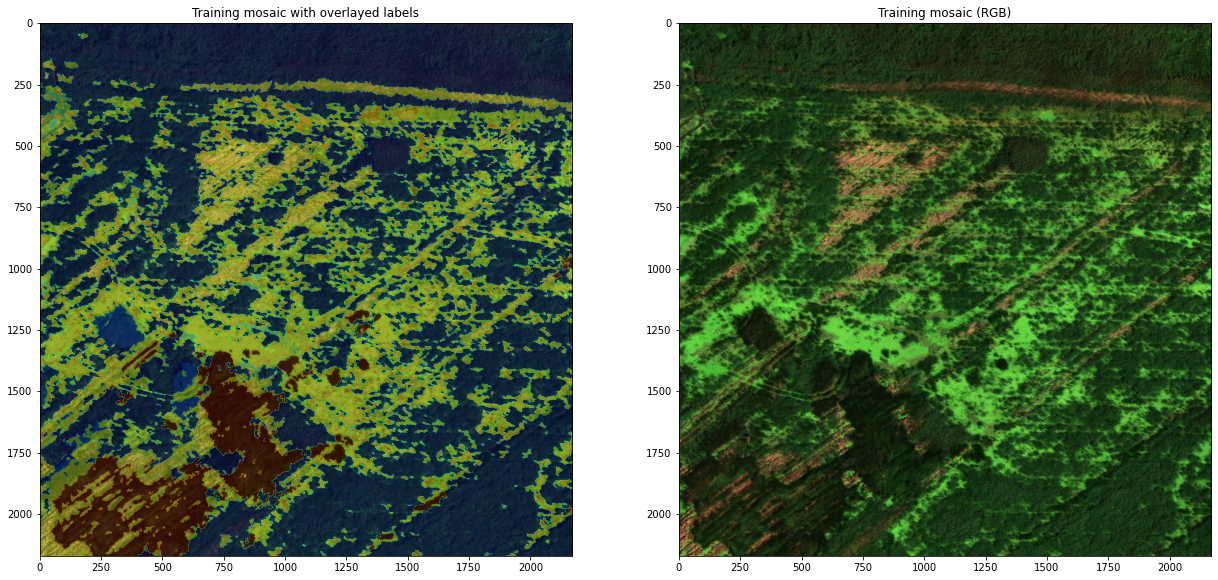

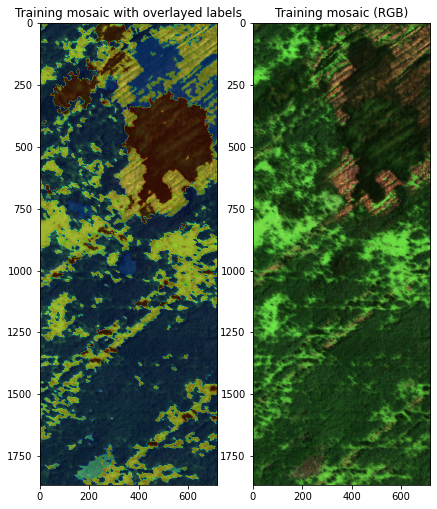

In [3]:
training_mosaic = np.array(tf.imread(os.path.join(mosaic_path, training_mosaic_file)))
training_mask = np.array(tf.imread(os.path.join(annot_path, training_labels_file)))
training_mask = np.clip(training_mask, 0, 5)

testing_mosaic = np.array(tf.imread(os.path.join(mosaic_path, val_mosaic_file)))
testing_mask = np.array(tf.imread(os.path.join(annot_path, val_labels_file)))
testing_mask = np.clip(testing_mask, 0, 5)

im_y, im_x, _ = training_mosaic.shape

c0 = training_mosaic[..., 0]
c0[c0 < 0] = 0
c1 = training_mosaic[..., 1]
c1[c1 < 0] = 0
c2 = training_mosaic[..., 2]
c2[c2 < 0] = 0
c3 = training_mosaic[..., 2]
c3[c3 < 0] = 0
c4 = training_mosaic[..., 2]
c4[c4 < 0] = 0

plt.figure(figsize=(im_x // 100, im_y // 200))
plt.subplot(1, 2, 1)
plt.imshow(
    np.stack([
        c2 / np.max(training_mosaic[..., :3]),
        c1 / np.max(training_mosaic[..., :3]),
        c0 / np.max(training_mosaic[..., :3])
    ], axis=-1)
)
plt.imshow(np.clip(training_mask, 0, 5) / 5, alpha=0.33, cmap='jet')
plt.title('Training mosaic with overlayed labels')

plt.subplot(1, 2, 2)
plt.imshow(
    np.stack([
        c2 / np.max(training_mosaic[..., :3]),
        c1 / np.max(training_mosaic[..., :3]),
        c0 / np.max(training_mosaic[..., :3])
    ], axis=-1)
)
plt.title('Training mosaic (RGB)')
training_mosaic = np.stack([c2, c1, c0, c3, c4], axis=-1)

c0 = testing_mosaic[..., 0]
c0[c0 < 0] = 0
c1 = testing_mosaic[..., 1]
c1[c1 < 0] = 0
c2 = testing_mosaic[..., 2]
c2[c2 < 0] = 0
c3 = testing_mosaic[..., 2]
c3[c3 < 0] = 0
c4 = testing_mosaic[..., 2]
c4[c4 < 0] = 0

im_y, im_x, _ = testing_mosaic.shape

plt.figure(figsize=(im_x // 100, im_y // 200))
plt.subplot(1, 2, 1)
plt.imshow(
    np.stack([
        c2 / np.max(testing_mosaic[..., :3]),
        c1 / np.max(testing_mosaic[..., :3]),
        c0 / np.max(testing_mosaic[..., :3])
    ], axis=-1)
)
plt.imshow(np.clip(testing_mask, 0, 5) / 5, alpha=0.33, cmap='jet')
plt.title('Training mosaic with overlayed labels')

plt.subplot(1, 2, 2)
plt.imshow(
    np.stack([
        c2 / np.max(testing_mosaic[..., :3]),
        c1 / np.max(testing_mosaic[..., :3]),
        c0 / np.max(testing_mosaic[..., :3])
    ], axis=-1)
)
plt.title('Training mosaic (RGB)')
testing_mosaic = np.stack([c2, c1, c0, c3, c4], axis=-1)

# Main function
The following cell contains the main function that will be used to run all the experiments for the dataset.

```python
def run_segmentation_experiments(
    master_seed, network_name, display_name, experiment_name, network_f, training_data, testing_data,
    weight_path, maps_path, classes=None, patch_size=256, overlap=128, epochs=10, patience=5,
    n_seeds=30, n_inputs=3, n_classes=2, train_batch=20, test_batch=50, saliency_batch=4, verbose=1
)
```

This is the main function involved in the experimentation process. To allow for multiple *random* runs, the function requires a **master_seed** (that defines the seed that will used to determine the seeds for each random run). Furthermore, a **network_name** is required for the weights file while a **display_name** is required to display debugging messages regarding the required *function* to instantiate the **network** that will be trained. The **classes** variable with a list of the class names and the **experiment_name** variables are also used to display messages regarding the results and experiment type.

For training and testing, a tuple of lists containing the mosaics and masks are required as **training_data** and **testing_data** for training and testing, respectively; and the **weight_path** and **maps_path** where the model weights and salienc maps will be stored. The other parameters relate to the network hyperparameters and training / optimisation parameters and are optional.

In [4]:
def run_segmentation_experiments(
    master_seed, network_name, display_name, experiment_name, network_f, training_data, testing_data,
    weight_path, maps_path, classes=None, patch_size=256, overlap=128, epochs=10, patience=5,
    n_seeds=30, n_inputs=3, n_classes=2, train_batch=20, test_batch=50, saliency_batch=4, verbose=1
):
    # Init
    training_mosaics, training_masks = training_data
    testing_mosaics, testing_masks = testing_data
    
    # While we use a BalancedLythrumDataset for training, it might
    # be a good idea to also use LythrumDataset. The choice of dataset
    # should be coherent with what we do on the other datasets.  
    training_set = BalancedMosaicDataset(
        training_mosaics, training_masks, patch_size, overlap
    )
    validation_set = MosaicDataset(
        training_mosaics, training_masks, patch_size, overlap
    )
    
    # Choosing random runs.
    np.random.seed(master_seed)
    seeds = np.random.randint(0, 100000, n_seeds)
    c = color_codes()

    dsc_list = []
    class_dsc_list = []
    # Main loop to run each independent random experiment.
    for test_n, seed in enumerate(seeds):
        acc = 0
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # The network will only be instantiated with the number of output classes
        # (2 in this notebok). Therefore, networks that need extra parameters (like ViT)
        # will need to be passed as a partial function.
        net = network_f(n_inputs=n_inputs, n_outputs=n_classes)
               
        # This is a leftover from legacy code. If init is set to True (the default option),
        # a first validation epoch will be run to determine the loss before training.
        net.init = False
        
        # The number of parameters is only captured for debugging and printing.
        n_param = sum(
            p.numel() for p in net.parameters() if p.requires_grad
        )

        if verbose > 1:
            print(
                '{:}[{:}] {:}Starting experiment {:}(seed {:05d} - {:} {:}[{:,} parameters]{:})'
                '{:} [{:02d}/{:02d}] {:}for {:} segmentation{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['b'] + display_name,
                    c['nc'], n_param, c['y'],
                    c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'], c['b'] + experiment_name + c['nc'] + c['g'], c['nc']
                )
            )
        
        training_loader = DataLoader(
            training_set, train_batch, True
        )
        validation_loader = DataLoader(
            validation_set, test_batch
        )
        model_path = os.path.join(
            weight_path, '{:}-balanced_s{:05d}_p{:03d}.pt'.format(network_name, seed, patch_size)
        )
        
        # For efficiency, we only run the code once. If the weights are
        # stored on disk, we do not need to train again.
        try:
            net.load_model(model_path)
        except IOError:
            net.train()
            print(''.join([' '] * 200), end='\r')
            net.fit(training_loader, validation_loader, epochs=epochs, patience=patience)
            net.save_model(model_path)
        
        if verbose > 2:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}[{:}] {:}Testing {:}(seed {:05d}){:} [{:02d}/{:02d}] '
                '{:}for {:} segmentation <{:03d} samples>{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'], c['b'] + experiment_name + c['nc'] + c['g'], 
                    len(training_set), c['nc']
                )
            )
        
        # Metric evaluation.
        net.eval()
        with torch.no_grad():
            mosaic_dsc = []
            mosaic_class_dsc = []
            # Intermediate buffers for class metrics.
            for input_mosaic, mask_i in zip(testing_mosaics, testing_masks):
                pred_map = net.patch_inference(
                    normalise(input_mosaic).astype(np.float32),
                    patch_size, test_batch
                )
            
                pred_y = np.argmax(pred_map, axis=0).astype(np.uint8)
                y = mask_i.astype(np.uint8)
                intersection = np.stack([
                    2 * np.sum(np.logical_and(pred_y == lab, y == lab))
                    for lab in range(n_classes)
                ])
                card_pred_y = np.stack([
                    np.sum(pred_y == lab) for lab in range(n_classes)
                ])
                card_y = np.stack([
                    np.sum(y == lab) for lab in range(n_classes)
                ])
                dsc_k = intersection / (card_pred_y + card_y)
                dsc = np.nanmean(dsc_k)
                mosaic_dsc.append(dsc)
                mosaic_class_dsc.append(dsc_k.tolist())

                for i, map_i in enumerate(softmax(pred_map, axis=0)):
                    map_path = os.path.join(
                        maps_path, '{:}-balanced_s{:05d}_map_{:02d}.png'.format(
                            network_name, seed, i
                        )
                    )
                    final_map = (255 * map_i).astype(np.uint8)
                    skio.imsave(map_path, final_map.astype(np.uint8))
                map_path = os.path.join(
                    maps_path, '{:}-balanced_s{:05d}_masks.png'.format(
                        network_name, seed
                    )
                )
                final_map = (255 * (pred_y / (n_classes - 1))).astype(np.uint8)
                skio.imsave(map_path, final_map.astype(np.uint8))
                
                dsc = np.nanmean(mosaic_dsc, axis=0)
                class_dsc = np.nanmean(mosaic_class_dsc, axis=0)
        if verbose > 2:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}[{:}] {:}DSC{:} (seed {:05d}){:} [{:02d}/{:02d}] {:}'
                '{:5.3f}{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['b'], dsc, c['nc']
                )
            )

            class_dsc_s = ', '.join([
            '{:} {:5.3f}'.format(k, dsc_k)
                for k, dsc_k in zip(classes, class_dsc)
            ])
            print(
                '{:}[{:}] {:}Class DSC{:} (seed {:05d}){:} [{:02d}/{:02d}] {:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['b'] + class_dsc_s + c['nc']
                )
            )
        elif verbose > 1:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}Seed {:05d} {:} [{:,} parameters] '
                '{:}[{:02d}/{:02d}] {:} {:5.3f}{:}'.format(
                    c['y'], seed, c['b'] + display_name + c['nc'], n_param,
                    c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'] + c['b'] + experiment_name + c['nc'] + c['b'],
                    dsc, c['nc']
                )
            )
        elif verbose > 0:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}Seed {:05d} {:} [{:,} parameters] '
                '{:}[{:02d}/{:02d}] {:} {:5.3f}{:}'.format(
                    c['y'], seed, c['b'] + display_name + c['nc'], n_param,
                    c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'] + c['b'] + experiment_name + c['nc'] + c['b'],
                    dsc, c['nc']
                ), end='\r'
            )
        net = None
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        dsc_list.append(mosaic_dsc)
        class_dsc_list.append(mosaic_class_dsc)
    
    # Metrics for all the runs.
    if verbose > 0:
        print(''.join([' '] * 200), end='\r')
        print(
            '{:}[{:}] {:} Mean DSC{:} {:5.3f}{:}'.format(
                c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"),
                c['nc'] + c['y'] + c['b'] + display_name + c['nc'] + c['g'],
                c['nc'] + c['b'], np.nanmean(dsc_list), c['nc']
            )
        )
        class_dsc_s = ', '.join([
            '{:} {:5.3f}'.format(k, dsc_k)
            for k, dsc_k in zip(
                classes, np.nanmean(class_dsc_list, axis=(0, 1))
            )
        ])
        print(
            '{:}[{:}] {:} Mean class DSC {:}'.format(
                c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), 
                c['nc'] + c['y'] + c['b'] + display_name + c['nc'] + c['g'],
                c['nc'] + c['b'] + class_dsc_s + c['nc']
            )
        )
        
    return dsc_list, class_dsc_list

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

master_seed = 42

train_batch = 32
test_batch = 64
patch_size = 128
overlap = 16
epochs = 50
patience = 50
name = 'wetland species'
classes = [
    'Phragmites australis', 'Cattail', 'Water',
    'Non-Photosynthetic Material', 'Algae', 'Bulrush'
]

image_path = os.path.join(
    d_path, 'Predictions', 'testing_image.png'
)
mosaic_rgb = testing_mosaic[..., :3]
skio.imsave(
    image_path, 
    (255 * (mosaic_rgb / np.max(mosaic_rgb))).astype(np.uint8)
)
mask_path = os.path.join(
    d_path, 'Predictions', 'testing_mask.png'
)
skio.imsave(mask_path, (255 * (testing_mask / 5)).astype(np.uint8))

# The experiments are run next. We capture some warnings related to
# image loading to clean the debugging console.
training_set = ([np.moveaxis(training_mosaic, -1, 0)], [training_mask])
testing_set = ([np.moveaxis(testing_mosaic, -1, 0)], [testing_mask])
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    # Unet [64, 64, 256, 256, 512, 512]
    unet_dsc, unet_k_dsc = run_segmentation_experiments(
        master_seed, 'unet2d', 'Unet 2D', name,
        partial(Unet2D, lr=1e-4, conv_filters=[64, 64, 256, 256, 512, 512]),
        training_set, testing_set, 
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=5, n_classes=6, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, overlap=overlap, verbose=1
    )
    
    # FCN ResNet50
    fcn50_dsc, fcn50_k_dsc = run_segmentation_experiments(
        master_seed, 'fcn-resnet50', 'FCN ResNet50', name,
        partial(FCN_ResNet50, lr=1e-4, pretrained=True),
        training_set, testing_set,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=5, n_classes=6, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, overlap=overlap, verbose=1
    )
    
    # FCN ResNet101
    fcn101_dsc, fcn101_k_dsc = run_segmentation_experiments(
        master_seed, 'fcn-resnet101', 'FCN ResNet101', name,
        partial(FCN_ResNet101, lr=1e-4, pretrained=True),
        training_set, testing_set,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=5, n_classes=6, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, overlap=overlap, verbose=1
    )

    # DeeplapV3 MobileNet
    dl3mn_dsc, dl3mn_k_dsc = run_segmentation_experiments(
        master_seed, 'deeplab3-mobilenet', 'DeeplabV3 MobileNet', name,
        partial(DeeplabV3_MobileNet, lr=1e-4, pretrained=True),
        training_set, testing_set,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        n_inputs=5, n_classes=6, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, overlap=overlap, verbose=1
    )

    # DeeplapV3 ResNet50
    dl3rn_dsc, dl3rn_k_dsc = run_segmentation_experiments(
        master_seed, 'deeplab3-resnet50', 'DeeplabV3 ResNet50', name,
        partial(DeeplabV3_ResNet50, lr=1e-4, pretrained=True),
        training_set, testing_set,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=5, n_classes=6, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, overlap=overlap, verbose=1
    )

    # L-RASPP ResNet50
    lraspp_dsc, lraspp_k_dsc = run_segmentation_experiments(
        master_seed, 'lraspp-mobilenet', 'Lite R-ASPP MobileNet', name,
        partial(LRASPP_MobileNet, lr=1e-4, pretrained=True),
        training_set, testing_set,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=5, n_classes=6, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, overlap=overlap, verbose=1
    )

KeyboardInterrupt: 